In [285]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import os
import numpy as np
from numpy import genfromtxt
import pandas as pd
import copy
from sklearn.manifold import TSNE
from sklearn.preprocessing import Imputer
from mpl_toolkits.mplot3d import Axes3D
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
import matplotlib.pyplot as plt
from sklearn import decomposition

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Data Preprocessing

## Data loading

In [27]:
gtex_gene_expression = pd.read_csv('gtex_gene_expression.csv')
genes = pd.read_csv('genes.csv')
gtex_donor = pd.read_csv('gtex_donor.csv')
gtex_gene_model = pd.read_csv('gtex_gene_model.csv')
gtex_sample = pd.read_csv('gtex_sample.csv')
gtex_tissue = pd.read_csv('gtex_tissue.csv')
tcga = pd.read_csv('tcga.csv') 
#gtex_sample_expression = pd.read_csv('gtex_sample_expression.csv')

## Healthy donor samples

In [36]:
path = './'
organ = ['Breast', 'HeadAndNeck', 'Kidney', 'Brain', 'Lung', 'Prostate', 'Thyroid', 'Uterus']
tissue2organ = dict()
for i in range(gtex_tissue.shape[0]):
    if gtex_tissue['organ'][i] in organ:
        tissue2organ[gtex_tissue['name'][i]] = gtex_tissue['organ'][i]

gtex_sample_expression = pd.read_csv(os.path.join(path, 'gtex_sample_expression.csv'))
rpkm = gtex_sample_expression.pivot(index='sample_id', columns='gene_id', values='rpkm_expression')
rpkm = rpkm.assign(sample_id=rpkm.index)
sample_id_tissue_pair = gtex_sample_expression.groupby(['sample_id','tissue']).size().reset_index().rename(columns={0:'count'})
sample_id_tissue_pair = sample_id_tissue_pair.assign(organ=[tissue2organ[t] if t in tissue2organ else '<Missing>' for t in sample_id_tissue_pair['tissue']])
merged = pd.merge(rpkm, sample_id_tissue_pair, on='sample_id')
cleaned = merged[merged['organ'] != '<Missing>']

df = dict()
for o in organ:
    temp = cleaned[cleaned['organ'] == o]
    df[o] = temp[temp.columns.values[:5000]]
    #df[o]['cancer'] = pd.Series(np.ones(length), index=organ_temp.index)
for o in organ:
    df[o]['cancer'] = 0
organ_healthy = df

## Cancer donor samples

In [48]:
# Preprocess cancer data
organ_cancer = {}
organs = ['Breast', 'HeadAndNeck', 'Kidney', 'Brain', 'Lung', 'Prostate',
       'Thyroid', 'Uterus']
for organ in organs:
    organ_temp = tcga[tcga['organ'] == organ]
    organ_temp = organ_temp.pivot(index = 'sample_number', columns = 'gene_id', values = 'fpkm_expression').sort_index()
    length = organ_temp.shape[0]
    organ_temp['cancer'] = pd.Series(np.ones(length), index=organ_temp.index)
    organ_cancer[organ] = organ_temp

## Dimension of processed data

In [58]:
# Description of cancer data
for organ in organs:
    print(organ, ": ", organ_cancer[organ].shape)

Breast :  (1222, 2843)
HeadAndNeck :  (546, 2843)
Kidney :  (611, 2843)
Brain :  (529, 2843)
Lung :  (594, 2843)
Prostate :  (551, 2843)
Thyroid :  (568, 2843)
Uterus :  (587, 2843)


# PCA decomposition for healthy/cancer

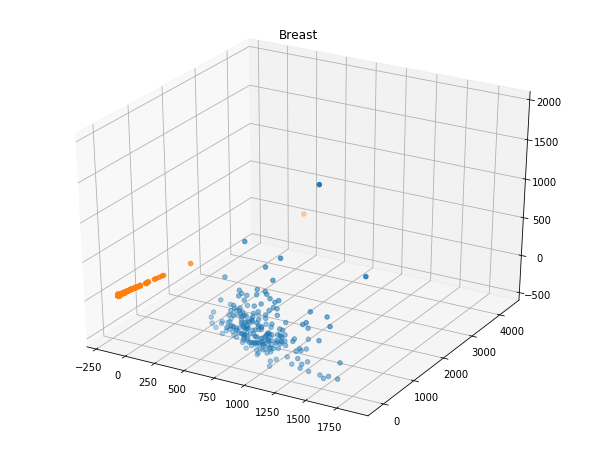

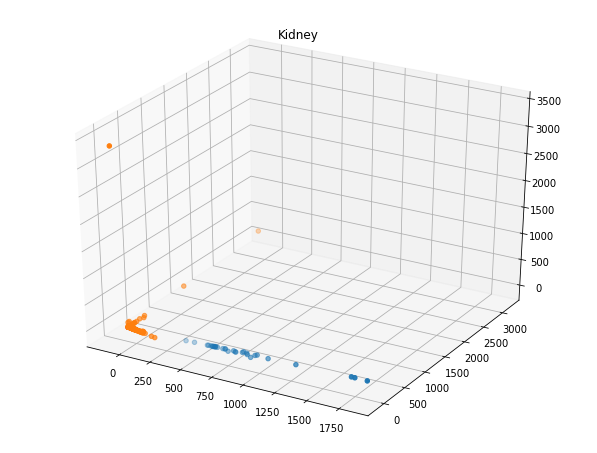

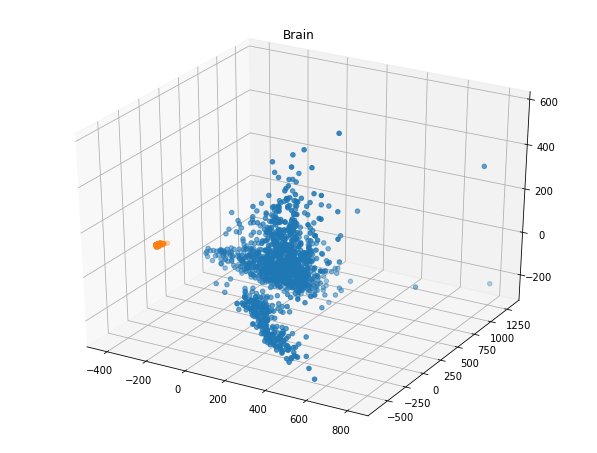

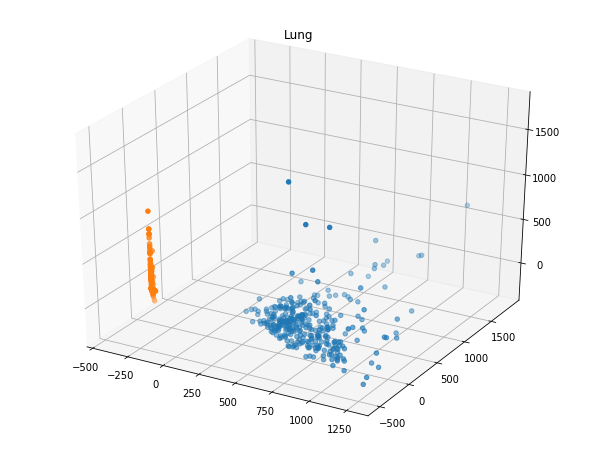

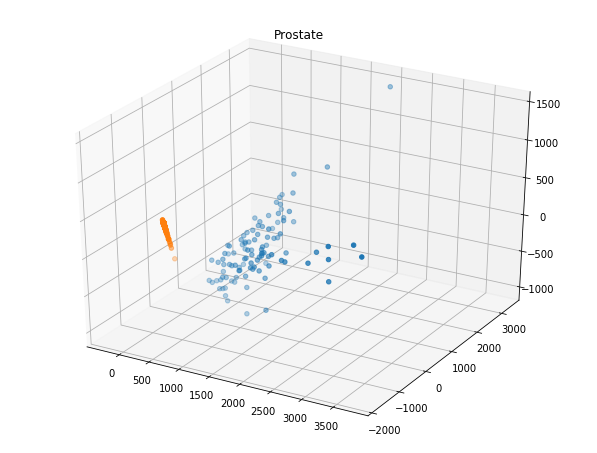

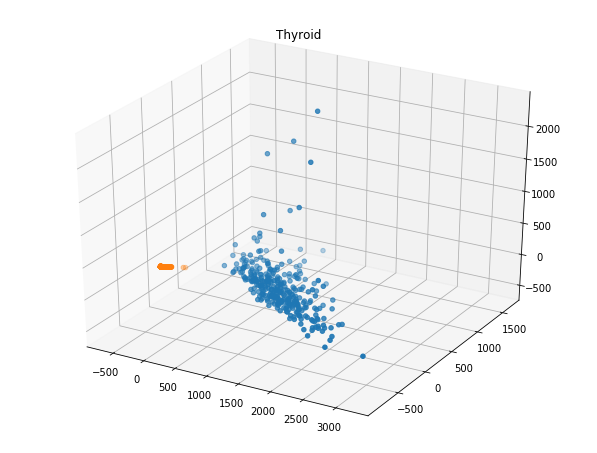

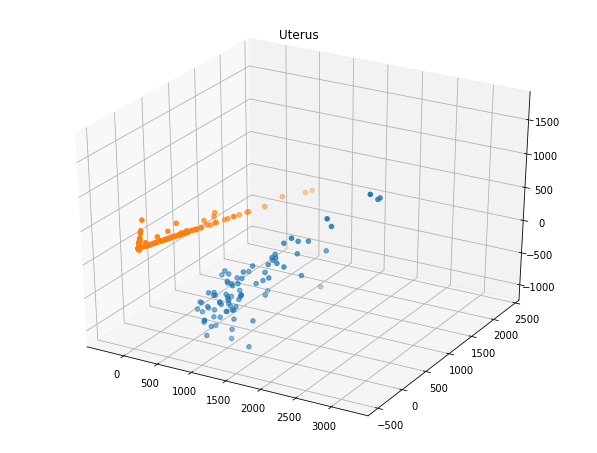

In [275]:
organs = ['Breast', 'Kidney', 'Brain', 'Lung', 'Prostate',
       'Thyroid', 'Uterus']

for o in organs:
    brain_healthy = organ_healthy[o]/2
    brain_cancer = organ_cancer[o]
    df = brain_cancer.append(brain_healthy)
    df = df.fillna(0)
    
    pca = decomposition.PCA(n_components=3)
    pca.fit(df[features])
    healthy = df[df['cancer']==0]
    cancer = df[df['cancer']==1]
    X = pca.transform(healthy[features])
    Y = pca.transform(cancer[features])

    fig = plt.figure(figsize=(8,6))
    ax = Axes3D(fig)
    ax.scatter(X[:,0],X[:,1], X[:,2])
    ax.scatter(Y[:,0],Y[:,1], Y[:,2])
    plt.title(o)
    plt.savefig(o + ".png")

# T-SNE decomposition for healthy/cancer

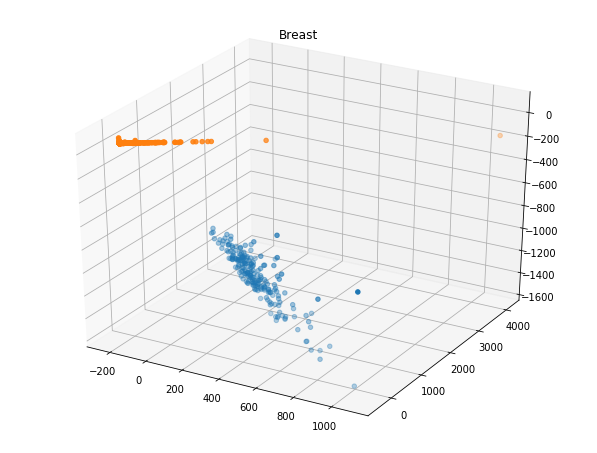

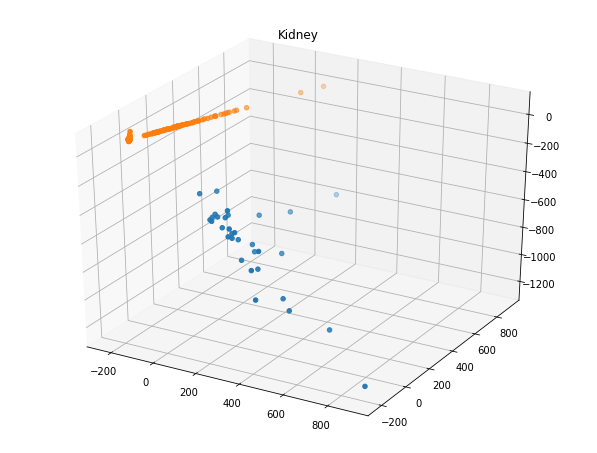

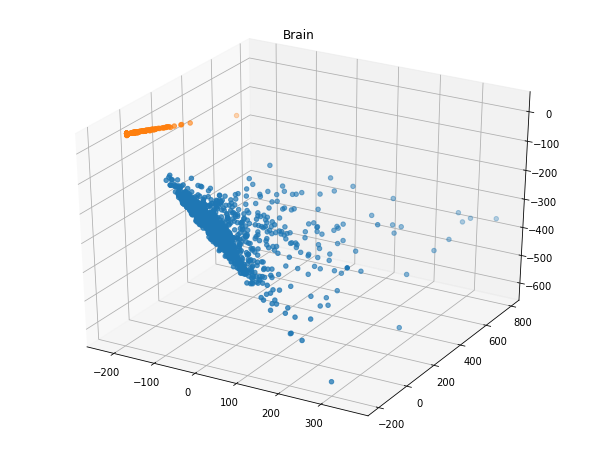

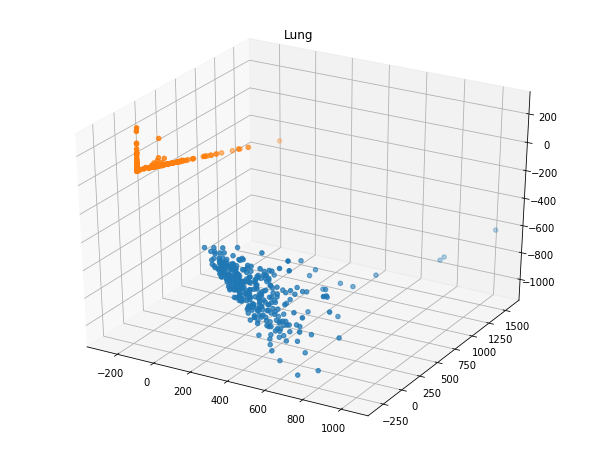

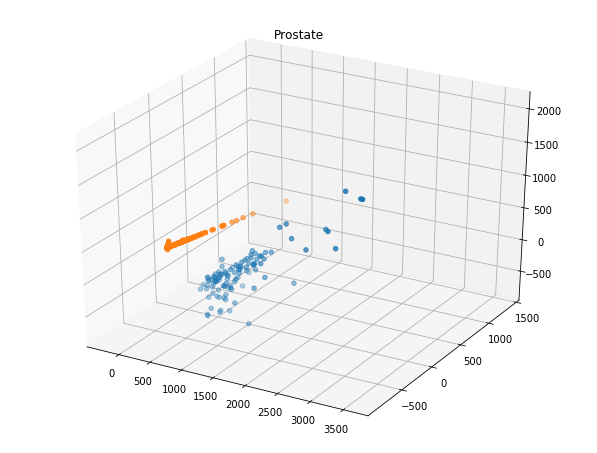

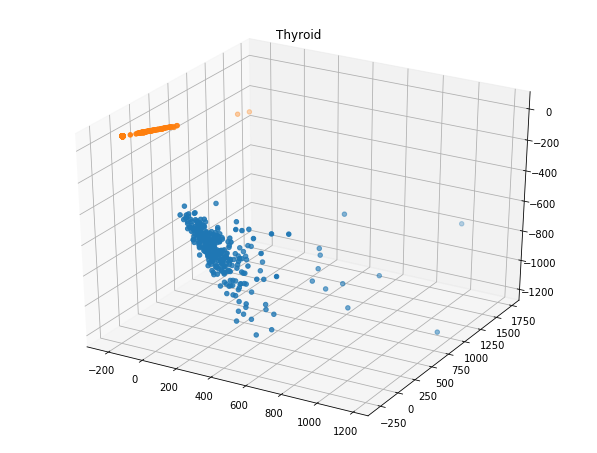

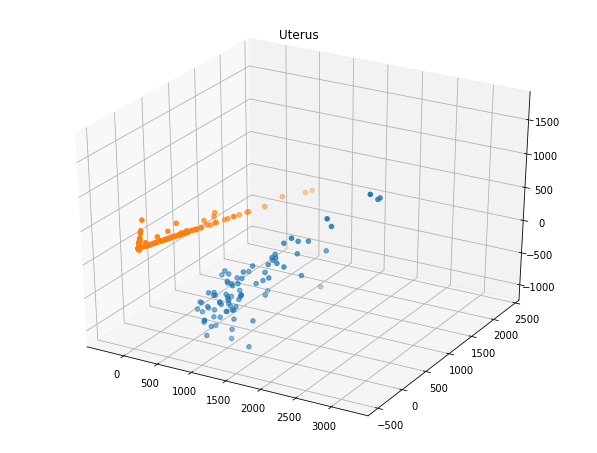

In [280]:
organs = ['Breast', 'Kidney', 'Brain', 'Lung', 'Prostate',
       'Thyroid', 'Uterus']

for o in organs:
    brain_healthy = organ_healthy[o]/2
    brain_cancer = organ_cancer[o]
    df = brain_cancer.append(brain_healthy)
    df = df.fillna(0)
    
    tsne = TSNE(n_components=3)
    tsne.fit(df[features])
    healthy = df[df['cancer']==0]
    cancer = df[df['cancer']==1]
    X = pca.transform(healthy[features])
    Y = pca.transform(cancer[features])

    fig = plt.figure(figsize=(8,6))
    ax = Axes3D(fig)
    ax.scatter(X[:,0],X[:,1], X[:,2])
    ax.scatter(Y[:,0],Y[:,1], Y[:,2])
    plt.title(o)
    plt.savefig(o + "_tsne.png")

# Marginal effects in prediction 

Organ: Breast
Number of observations in the training data: 1093
Number of observations in the test data: 343
Organ: Kidney
Number of observations in the training data: 490
Number of observations in the test data: 153
Organ: Brain
Number of observations in the training data: 1393
Number of observations in the test data: 395
Organ: Lung
Number of observations in the training data: 684
Number of observations in the test data: 230
Organ: Prostate
Number of observations in the training data: 473
Number of observations in the test data: 184
Organ: Thyroid
Number of observations in the training data: 678
Number of observations in the test data: 213
Organ: Uterus
Number of observations in the training data: 502
Number of observations in the test data: 168


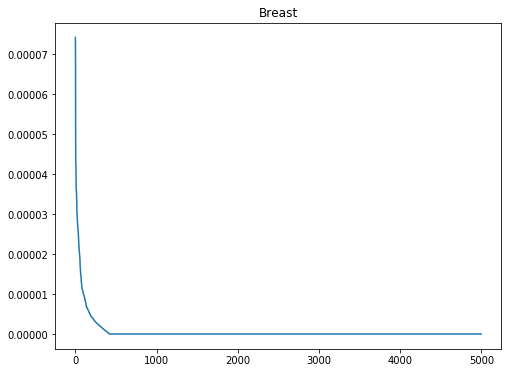

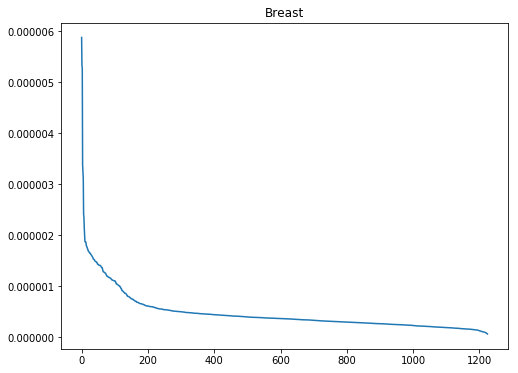

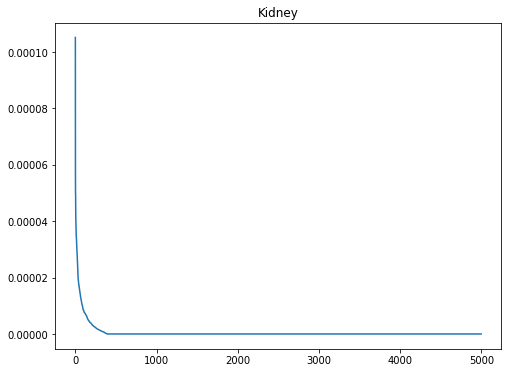

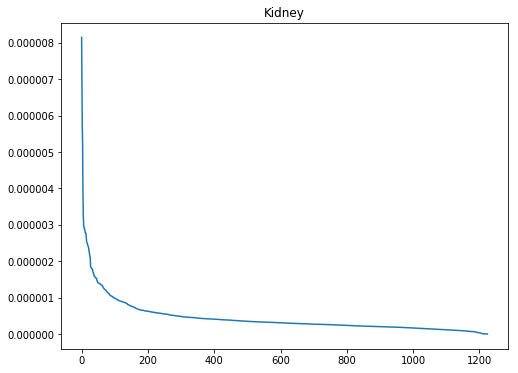

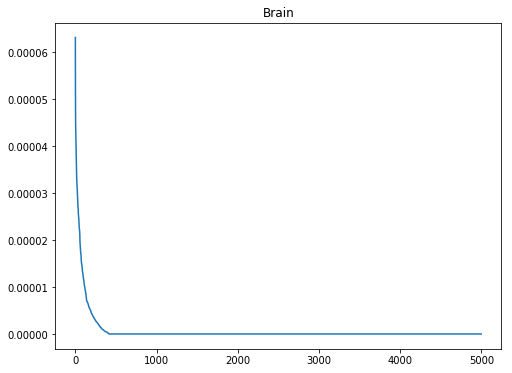

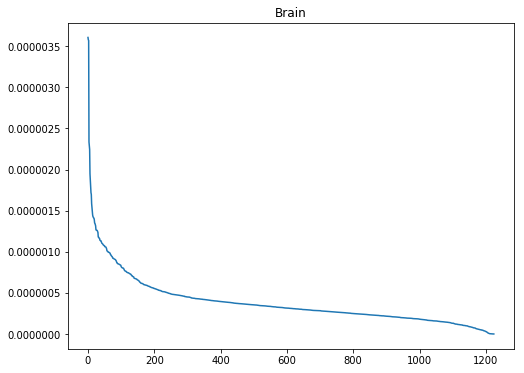

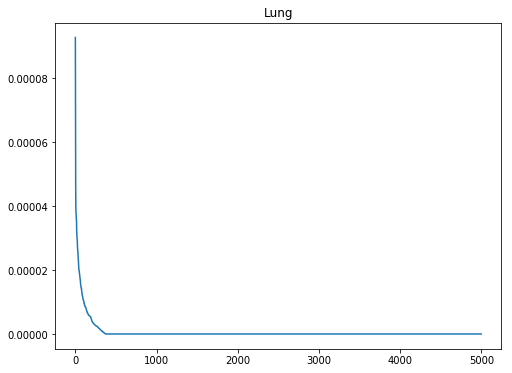

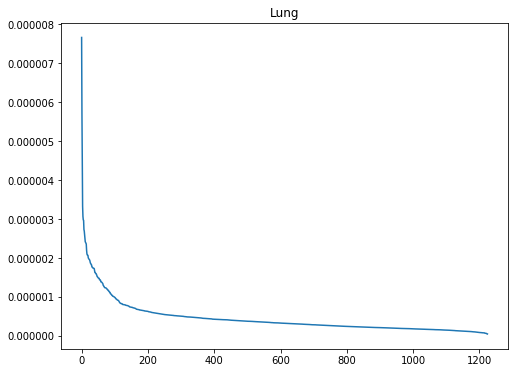

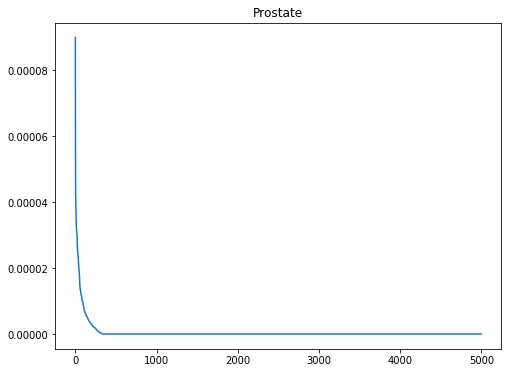

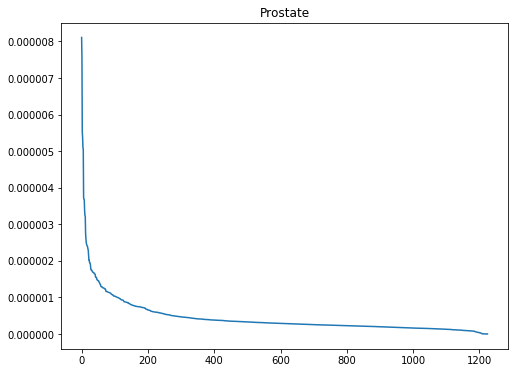

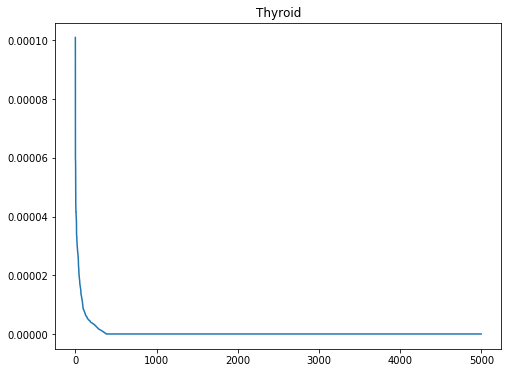

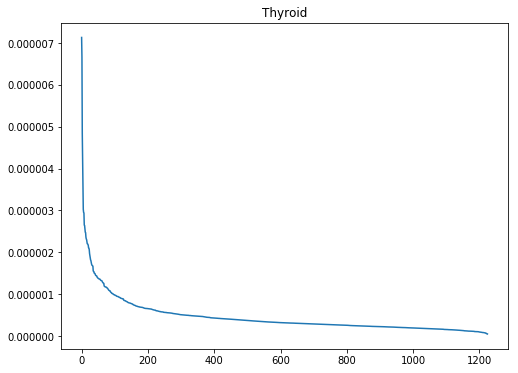

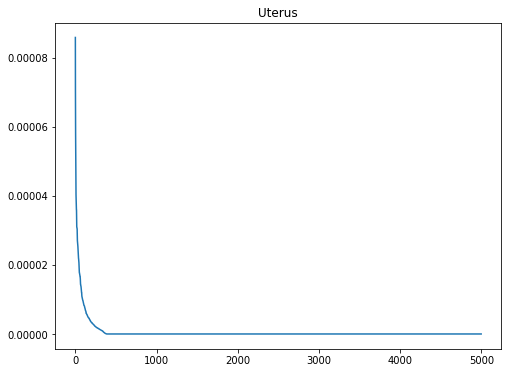

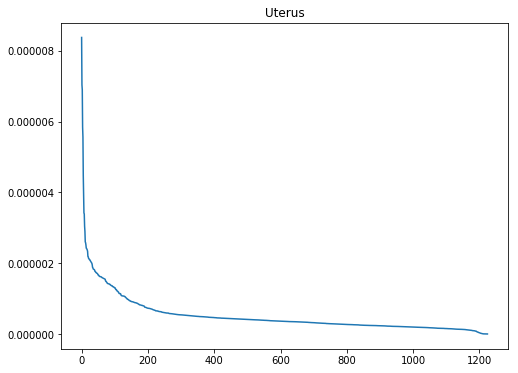

In [294]:
effects = {}
d1 = {}
d2 = {}
effects2 = {}
for o in organs:
    brain_healthy = organ_healthy[o]/2
    brain_cancer = organ_cancer[o]
    df = brain_cancer.append(brain_healthy)
    #df = df.fillna(0)
    # Train/test split 
    df['is_train'] = np.random.uniform(0, 1, len(df)) <= .75
    train, test = df[df['is_train']==True], df[df['is_train']==False]
    print('Organ: {}'.format(o))
    print('Number of observations in the training data:', len(train))
    print('Number of observations in the test data:',len(test))
    imputer = Imputer()
    data = pd.read_csv('brain.csv')
    col_names = data.columns.values[1:-2]

    raw_data = data[col_names].values
    data[col_names] = imputer.fit_transform(raw_data)

    data_train = data[data['is_train'] == True]
    data_test = data[data['is_train'] != True]

    X_train = data_train[col_names]
    y_train = data_train['cancer']
    X_test = data_test[col_names]
    y_test = data_test['cancer']

    LR_l1 = LogisticRegression(penalty='l1', tol=0.01)
    LR_l1.fit(X_train,y_train)
    
    delta = 1.1
    prob = LR_l1.predict_proba(X_test)
    d_prob = np.zeros(5000)
    for i in range(5000):
        X_test_copy = copy.deepcopy(X_test)
        X_test_copy[col_names[i]] *= delta
        prob_i = LR_l1.predict_proba(X_test_copy)
        d_prob[i] = np.mean(np.abs(prob_i[:,1] - prob[:,1]))
        d_prob_sorted = sorted([(i,d_prob[i]) for i in range(5000)], key=lambda t:-t[1])
        gene_important = [col_names[d_prob_sorted[i][0]] for i in range(50)]
    
    dd_prob = np.zeros(50 * 49 // 2)

    idx2pair = [(i,j) for i in range(49) for j in range(i+1,50)]
    for idx in range(50 * 49 // 2):
        i, j = idx2pair[idx]
        X_test_copy_i = copy.deepcopy(X_test)
        X_test_copy_j = copy.deepcopy(X_test)

        X_test_copy_i[gene_important[i]] *= delta
        prob_i = LR_l1.predict_proba(X_test_copy_i)

        X_test_copy_j[gene_important[j]] *= delta
        prob_j = LR_l1.predict_proba(X_test_copy_j)

        X_test_copy_i[gene_important[j]] *= delta
        prob_ij = LR_l1.predict_proba(X_test_copy_i)
        dd_prob[idx] = np.mean(np.abs(prob_ij[:,1] - prob_i[:,1] - prob_j[:,1] + prob[:,1]))
        dd_prob_sorted = sorted([(idx, dd_prob[idx]) for idx in range(50 * 49 // 2)], key=lambda t:-t[1])
        gene_important_2 = [(gene_important[idx2pair[dd_prob_sorted[i][0]][0]], gene_important[idx2pair[dd_prob_sorted[i][0]][1]]) for i in range(50)]
    
    d1[o] = d_prob_sorted
    d2[o] = dd_prob_sorted
    effects[o] = [effect for _, effect in d_prob_sorted]
    effects2[o] = [effect for _, effect in dd_prob_sorted]
    
    fig = plt.figure(figsize=(8,6))
    plt.title(o)
    plt.plot(range(len(effects[o])), effects[o])
    plt.savefig(o + "_effects.png")
    
    fig = plt.figure(figsize=(8,6))
    plt.title(o)
    plt.plot(range(len(effects2[o])), effects2[o])
    plt.savefig(o + "_effects2.png")

# Other classification methods

## Prepare

In [226]:
# Train/test split 
df['is_train'] = np.random.uniform(0, 1, len(df)) <= .75
train, test = df[df['is_train']==True], df[df['is_train']==False]
print('Number of observations in the training data:', len(train))
print('Number of observations in the test data:',len(test))
df.to_csv('brain.csv')
# Labels
y = pd.factorize(train['cancer'])[0]

Number of observations in the training data: 1345
Number of observations in the test data: 443


## Random forest

In [228]:
# Create a random forest Classifier. By convention, clf means 'Classifier'
#clf = RandomForestClassifier(n_jobs=2, random_state=2, )
clf = LogisticRegression(C=2, penalty='l1', tol=0.01)

# Train the Classifier to take the training features and learn how they relate
# to the training y (the species)
clf.fit(train[features], y)

preds = clf.predict(test[features])
pd.crosstab(test['cancer'], preds, rownames=['Actual'], colnames=['Predicted'])

LogisticRegression(C=2, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.01,
          verbose=0, warm_start=False)

## Lasso logistic regression

In [216]:
clf_l1_LR = LogisticRegression(C=2, penalty='l1', tol=0.01)
clf_l1_LR.fit(train[features], y)

preds = clf_l1_LR.predict(test[features])
pd.crosstab(test['cancer'], preds, rownames=['Actual'], colnames=['Predicted'])

LogisticRegression(C=2, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.01,
          verbose=0, warm_start=False)

## SVM

In [223]:
clf_svm = svm.SVC(class_weight={0:1,1:10000})
clf_svm.fit(train[features], y)
preds = clf_svm.predict(test[features])
pd.crosstab(test['cancer'], preds, rownames=['Actual'], colnames=['Predicted'])

Predicted,0,1
Actual,,
0.0,0,311
1.0,129,22
